# Builder Tutorial number 4

The builder tutorials demonstrate how to build an operational GSFLOW model using `pyGSFLOW` from shapefile, DEM, and other common data sources. These tutorials focus on the `gsflow.builder` classes.

## Performing watershed (basin) delineation and subbasin delineation

In this tutorial, we demonstrate how to perform watershed and subbasin delineation to define model boundaries and contributing area zones (subbasins). Performing watershed delineation is necessary for building an operational GSFLOW model. Subbasin delineation is an optional, but useful method that allows users to isolate contributing areas.

In [1]:
import os
import shapefile
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import flopy
from gsflow.builder import GenerateFishnet

### The `FlowAccumulation` class (refresher)

The `FlowAccumulation` class performs many operations including generating flow direction arrays and flow accumulation arrays. This example notebook focuses is on the `flow_direction` and `flow_accumulation` methods of this class. Other methods are presented in following tutorials.

The `FlowAccumulation` class has 3 required parameters and 5 optional input parameters:  

**REQUIRED Parameters**
   - `data` : resampled dem data array of dimension nrow, ncol (matches modelgrid dimension)
   - `xcenters` : a two dimensional array of x coordinate cell centers (dimension nrow, ncol)
   - `ycenters` : a two dimensional array of y coordinate cell centers (dimension nrow, ncol)

**OPTIONAL Parameters**
   - `acc_type` : flow accumlation type, currently only "d8" is supported
   - `hru_type` : optional hru_type array where 0=inactive, 1=land, 2=lake, and 3=swale
   - `closed_basin` : If true hru_type 2 is used in the flow direction calculations. False ignores hru_type 2. Default is False.
   - `flow_dir_array` : previously calculated flow direction array. This parameter is used to restart the class without performing flow direction analysis
   - `verbose` : boolean flag to print verbose output

Let's start with importing the class.

In [2]:
from gsflow.builder import FlowAccumulation

## Applying the methods to the Sagehen 50m example problem

In this example the methods are applied directly to the Sagehen 50m model as they are presented.

In [3]:
# define the input and output data paths
input_ws = os.path.join("data", "sagehen", "50m_tutorials")
shp_ws = os.path.join("data", "geospatial")
output_ws = os.path.join("data", "temp")

# define the modelgrid and resampled DEM data paths
mg_file = os.path.join(input_ws, "sagehen_50m_grid.bin")
dem_data = os.path.join(input_ws, "sagehen_50m_dem.txt")

# define the flow direction and flow accumulation data paths
flowdir_file = os.path.join(input_ws, "sagehen_50m_flowdir.txt")
flowacc_file = os.path.join(input_ws, "sagehen_50m_flowacc.txt")

# shapefile pour point
shp_file = os.path.join(shp_ws, "model_points.shp")

Load the previously processed data

In [4]:
# load modelgrid, dem, flow directions, and flow accumulation
modelgrid = GenerateFishnet.load_from_file(mg_file)
dem_data = np.genfromtxt(dem_data)
flow_directions = np.genfromtxt(flowdir_file, dtype=float)
flow_accumulation = np.genfromtxt(flowacc_file)

### Restarting the `FlowAccumulation` class from existing data

In this tutorial series, the flow direction and flow accumulation calculations were performed in the previous builder tutorial. Instead of re-running these calculations, which can be time consuming for very large models, we can provide the saved flow direction array to the class as a way of restarting the solution.

To restart from the previous solution, the saved flow direction array is passed to the `flow_dir_array` parameter during instantiation as shown in this example

In [5]:
fa = FlowAccumulation(
    dem_data,
    modelgrid.xcellcenters,
    modelgrid.ycellcenters,
    flow_dir_array=flow_directions,
    verbose=True
)

Now the `FlowAccumulation` object is ready to perform basin and subbasin deliniation.

### Watershed (basin) Delineation

The watershed (basin) delineation routine uses information from the stored flow direction array to map watershed boundaries based on topographical divides within the watershed. This method is not automatic, and gives the user flexibility to define the basin outlet in which the watershed will be defined from.

The `define_watershed` method performs watershed deliniation and has the following parameters:
   - `pour_point` : three seperate input methods can be used to define the pour point as described below
      - list of [(xcoordinate, ycoordinate)] location that define the pour point
      - list of [(row, column)] location that define the pour point
      - shapefile name, file contains a single pour point that defines the basin outlet
   - `modelgrid` : modelgrid instance from `GenerateFishnet` (flopy.discretization.StructuredGrid object)
   - `fmt` : format of pour point input ("xy" for xy coordinates, "rowcol" for row column, "shp" for shapefile)
   
This example demonstrates how to use an xy coordinate that is extracted from an existing shapefile point. 

In [6]:
# read in our pour point from a shapefile as an xy coordinate
with shapefile.Reader(shp_file) as r:
    shape = r.shape(0)
    pour_point = shape.points

print(pour_point)

[[221298.4058475063, 4369674.979622432]]


Now that the pour point is loaded, watershed delineation can be run using `define_watershed()`

In [7]:
watershed = fa.define_watershed(pour_point, modelgrid, fmt="xy")

structuredgrid.py:777: UserWarning: The interface 'intersect(self, x, y, local=False, forgive=False)' has been deprecated. Use the intersect(self, x, y, z=None, local=False, forgive=False) interface instead.
structuredgrid.py:777: UserWarning: The interface 'intersect(self, x, y, local=False, forgive=False)' has been deprecated. Use the intersect(self, x, y, z=None, local=False, forgive=False) interface instead.


Now the watershed has been generated and it can be inspected

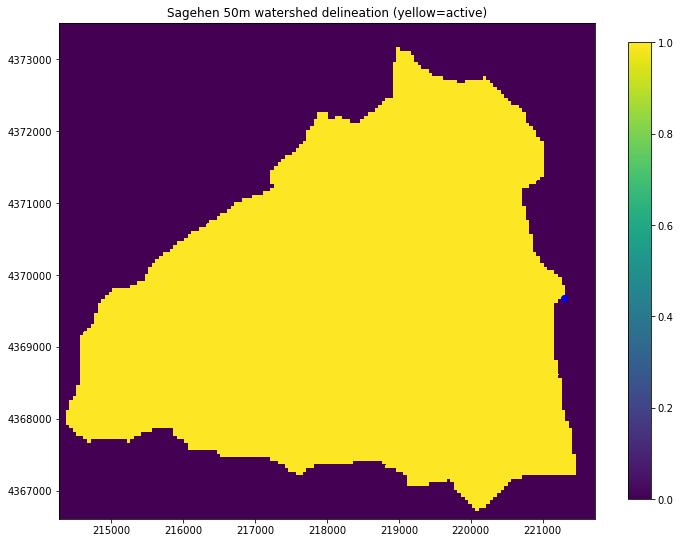

In [8]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, aspect="equal")

pmv = flopy.plot.PlotMapView(modelgrid=modelgrid, ax=ax)
pc = pmv.plot_array(
    watershed, vmin=0, vmax=1,
)
plt.plot(*pour_point[0], 'bo')
plt.colorbar(pc, shrink=0.7)
plt.title("Sagehen 50m watershed delineation (yellow=active)")
plt.show();

### Subbasin delineation

Subbasin delineation can be performed in much the same way as watershed delineation.Once again,  this method is not automatic, and gives the user flexibility to define the subbasin outlets in which the watershed will be defined from. The benefit of this approach is that the user can identify areas of interest and/or define subbasins based on existing stream gages to isolate the contributing areas to that particular area.

The `define_subbasins()` method performs subbasin delineation and has the following input parameters:
   - `pour_points` : three seperate input methods can be used to define the pour points as described below
      - list of [(xcoordinate0, ycoordinate0),...(xcoordinaten, ycoordinaten] locations that define the pour points
      - list of [(row0, column0),...(rown, columnn)] locations that define the pour points
      - shapefile name, file contains pour points that define the subbasin outlets
   - `modelgrid` : modelgrid instance from `GenerateFishnet` (flopy.discretization.StructuredGrid object)
   - `fmt` : format of pour point input ("xy" for xy coordinates, "rowcol" for row column, "shp" for shapefile)


*Note: this example is for illustrative puposes only and is not applied to the operational Sagehen 50m model.*

In [9]:
# Let's create some pour point data!
pour_points = []
# add our watershed outlet as row column location
pour_points.append(modelgrid.intersect(pour_point[0][0], pour_point[0][1]))
pour_points += [(73, 118), (69, 67), (64, 71)]
pour_points[::-1]

structuredgrid.py:777: UserWarning: The interface 'intersect(self, x, y, local=False, forgive=False)' has been deprecated. Use the intersect(self, x, y, z=None, local=False, forgive=False) interface instead.


[(64, 71), (69, 67), (73, 118), (76, 140)]

Now define the subbasins using the "rowcol" fmt for pour points

In [10]:
subbasins = fa.define_subbasins(
    pour_points,
    modelgrid,
    fmt="rowcol"
)

Now the subbasins have been generated and can be inspected

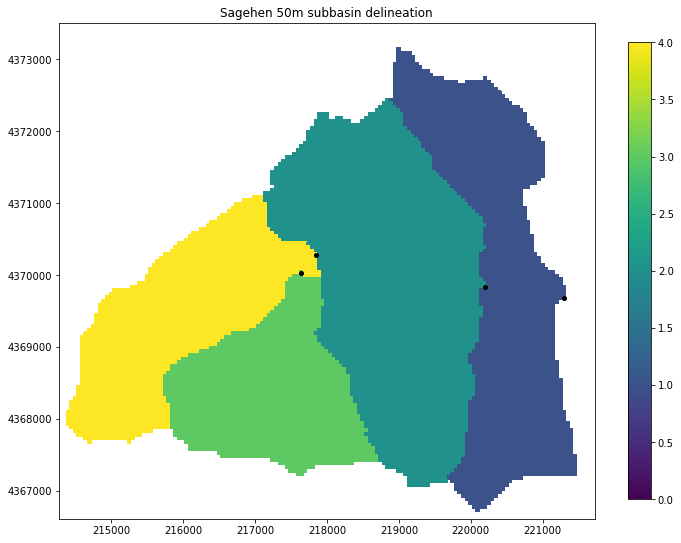

In [11]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, aspect="equal")

pmv = flopy.plot.PlotMapView(modelgrid=modelgrid, ax=ax)
pc = pmv.plot_array(
    subbasins, vmin=0, vmax=4, masked_values=[0,]
)
for r, c in pour_points:
    xc, yc = modelgrid.xcellcenters[r, c], modelgrid.ycellcenters[r, c]
    plt.plot(xc, yc, 'ko', ms=4)
plt.colorbar(pc, shrink=0.7)
plt.title("Sagehen 50m subbasin delineation")
plt.show();

## Saving the watershed delineation and subbasin delineation arrays for later use

The builder methods allow the user to save the watershed and subbasin delineation arrays and pick up where they left off in another session or script.

These arrays can be saved using numpy's `savetxt()` method.

*In the next tutorial we will load the watershed delineation and pick up from where we left off*

In [12]:
np.savetxt(
    os.path.join(output_ws, "sagehen_50m_watershed.txt"),
    watershed.astype(int),
    delimiter="  ",
    fmt="%d"
)

np.savetxt(
    os.path.join(output_ws, "sagehen_50m_subbasin.txt"),
    subbasins.astype(int),
    delimiter="  ",
    fmt="%d"
)